In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()
from pyforest import *
from src.utils.notebook_imports import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import model_from_json


# define GPU id to use
# 0 = 1080 Bus ID 2
# 1 = Titan Bus ID 131
# 2 = Titan Bus ID 132
gpu_id = '1'
current_gpu = choose_gpu_by_id(gpu_id)

from src.utils.utils_io import Console_and_file_logger, ensure_dir
from src.utils.myshow import myshow, myshow3d
import src.utils.my_metrics as metr
import src.utils.medley_metrics as m_metrics
from src.data.generators import DataGenerator, get_samples
from src.data.dataset import get_img_msk_files_from_split_dir, get_z_position_from_filename, get_t_position_from_filename, get_patient
from src.models.ModelManager import get_optimizer
from src.data.Dataset_utils import load_config
from src.utils.Evaluation import sanity_check
from src.visualization.visualize import plot_confusion_matrix, show_slice, show_slice_transparent, show_2D_or_3D
from src.utils.my_metrics import dice_numpy
from medpy.metric.binary import hd, dc,jc,precision,recall


#Console_and_file_logger('Evaluation', logging.INFO)
%matplotlib inline
%reload_ext autoreload
%autoreload 2

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_background,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]


search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio
using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch


Using TensorFlow backend.


In [6]:
def calc_per_label_scores(pred, y, metric):
    """
    returns a tuple with score, score_rv, score_myo, score_lv
    """
    # background = 0 = Y[:,:,0] RV = 1 = Y[:,:,1] # Myo = 2 = Y[:,:,2] # LV = 3 = Y[:,:,3]
    label_channels = [1,2,3]
    scores = []
    try:
        scores.append(metric(pred[...,1:],y[...,1:]))
    except Exception as e:
        logging.debug(('error with score: {}'.format(str(e))))
        scores.append(1.0)
        
    for label in label_channels:
        try:
            scores.append(metric(pred[...,label], y[...,label]))
        except Exception as e: # jc from medpy could lead to division by zero
            scores.append(1.0) # ignore images with no label
            #logging.error('error with label: {}, {}'.format(label, str(e)))
    return scores


In [2]:
@interact
def load_config_interactive(config_file=sorted(glob.glob('reports/configs/2D/kfoldgcn_unsigned/acdc/**/**/*.json')), load=False):
    # load_config_interactive(config_file=sorted(glob.glob('reports/configs/2D/mask_values/**/**/*.json', recursive=False)), load=False):
    """
    # def load_config_interactive(config_file=sorted(glob.glob('reports/configs/2D/acdc/finetune_new/**/**/*.json', recursive=False)), load=False):

    load config, tranings history and model
    """
    # load config with all params into global namespace
    glob_ = load_config(config_file_path=config_file, load=load)
    
    # update global namesspace to make config, model and evaluation score accessible
    globals().update(glob_)
    
    if globals().get('model', False):
        model.compile(optimizer=config['OPTIMIZER'], loss=metr.bce_dice_loss, metrics=metrics)
    # print current config, and create new logger instance
    config['RESAMPLE'] = False
    config['AUGMENT_GRID'] = False
    logging.info('Experiment: {}'.format(config['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))

    

interactive(children=(Dropdown(description='config_file', options=('reports/configs/2D/kfoldgcn_unsigned/acdc/…

In [3]:
@interact
def evaluate_per_area_with_dataframe(fold=range(4),
                                     c_file=sorted(glob.glob('reports/configs/2D/kfoldgcn_unsigned/acdc/**/**/*.json')), 
                                     dataset=['gcn', 'acdc'], 
                                     modality=['all','train', 'test'], 
                                     area = ['all', 'lower', 'middle', 'upper'],
                                     df_path = 'data/raw/GCN/2D/df_kfold.csv',
                                     start=False,
                                    load_new=True):
    """
    Run model evaluation with all compiled metrics for a dataframe
    """
    if start:
        #keras.backend.set_learning_phase(0)
        # select the correct config for this fold
        #c_file = sorted(glob.glob('reports/configs/2D/kfold/**/*.json', recursive=False))[fold]
        #c_file = sorted(glob.glob('reports/configs/2D/kfold/unet_tetra_spacing1_batch32_drop04_batchnorm_minmax_kfold/**/*.json'))[0]
        # update config & model for the current evaluation
        # load config with all params into global namespace
        if load_new: # if we reuse a model and config, we dont need to reload/compile the model to save time
            glob_ = load_config(config_file_path=c_file, load=True)
    
            # update global namesspace to make config and model accesible
            globals().update(glob_)
            gcn_patients = config.get('GCN_PATIENTS', False)
            logging.info(gcn_patients)
        
        # no resample and augmentation
        config['RESAMPLE'] = False
        config['AUGMENT_GRID'] = False
        
        if globals().get('model', False):
            model.compile(optimizer=get_optimizer(config), loss=metr.bce_dice_loss, metrics=metrics)
        # print current config
        logging.info('Experiment: {}'.format(config['EXPERIMENT']))
        #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
        
        # evaluae on data from this dataframe
        df_folds = pd.read_csv(df_path)

        # select the corresponding fold of data
        df_fold = df_folds[df_folds['fold'] == fold]
        
        # filter patients which were used during training
        gcn_patients = config.get('GCN_PATIENTS', False)
        if gcn_patients: # exclude all GCN patients that were used during training
            logging.info('filter: {}'.format(gcn_patients))
            df_fold = df_fold[~df_fold['patient'].isin(gcn_patients)]
        
        path_as_string = '{}_{}_{}_{}_{}'.format(config.get('EXPERIMENT', 'temp'), dataset, area, str(fold), modality)
        
        # load filenames
        if area == 'all' and modality == 'all':
            # get the current folded train/validation data
            df_fold = df_folds[df_folds['fold'] == fold]
            X_train = sorted(df_fold[df_fold['modality'] == 'train']['x_path'])
            Y_train = sorted(df_fold[df_fold['modality'] == 'train']['y_path'])
            X_test = sorted(df_fold[df_fold['modality'] == 'test']['x_path'])
            Y_test = sorted(df_fold[df_fold['modality'] == 'test']['y_path'])
            
            X_test = X_train + X_test
            Y_test = Y_train + Y_test
            
        elif area == 'all' and modality in ['train', 'test']:
            
            X_test = sorted(df_fold[df_fold['modality'] == modality]['x_path'])
            Y_test = sorted(df_fold[df_fold['modality'] == modality]['y_path'])
            
        else: # load only filenames for a special area of the heart, samples = 0 --> load all patients from this area from the path
            X_test, Y_test = get_samples(path=path, samples=0, part=area, no_patients = 0, preprocessed=False)
        
        # evaluate testdata
        test_generator = DataGenerator(X_test, Y_test, config)

        scores_test = model.evaluate(test_generator, verbose=1)

        logging.info('evaluation for: {} done'.format(path_as_string))
        # define cols
        col = ['Evaluation'] +  model.metrics_names
        row_test = scores_test
        # get evaluation score from global namespace, or create a new one
        scores_df = globals().get('evaluation_score', None)
        if scores_df is None:
            scores_df = pd.DataFrame(columns=col).set_index('Evaluation')
        # add current evaluations as new rows
        scores_df.loc[path_as_string] = scores_test
        scores_df = scores_df.sort_index()
        
        globals()['evaluation_score'] = scores_df
        export_path = os.path.join('reports/evaluation', config['EXPERIMENT'])
        ensure_dir(export_path)
        #scores_df.to_csv(os.path.join(export_path,'evaluation_score.csv'))
        logging.info('Scores saved to: {}'.format(export_path))
        return scores_df

interactive(children=(Dropdown(description='fold', options=(0, 1, 2, 3), value=0), Dropdown(description='c_fil…

# test the hard dice

In [7]:
@interact
def evaluate_per_slice_with_dataframe(fold=range(4),
                                     c_file=sorted(glob.glob('reports/configs/2D/kfoldgcn_unsigned/acdc/**/**/*.json')), 
                                     dataset=['gcn', 'acdc'], 
                                     modality=['all','train', 'test'], 
                                     area = ['all', 'lower', 'middle', 'upper'],
                                     df_path = 'data/raw/GCN/2D/df_kfold.csv',
                                     start=False,
                                    load_new=True):
    """
    Run model evaluation with all compiled metrics for a dataframe
    """
    if start:
        #keras.backend.set_learning_phase(0)
        # select the correct config for this fold
        #c_file = sorted(glob.glob('reports/configs/2D/kfold/**/*.json', recursive=False))[fold]
        #c_file = sorted(glob.glob('reports/configs/2D/kfold/unet_tetra_spacing1_batch32_drop04_batchnorm_minmax_kfold/**/*.json'))[0]
        # update config & model for the current evaluation
        # load config with all params into global namespace
        if load_new: # if we reuse a model and config, we dont need to reload/compile the model to save time
            glob_ = load_config(config_file_path=c_file, load=True)
    
            # update global namesspace to make config and model accesible
            globals().update(glob_)
            gcn_patients = config.get('GCN_PATIENTS', False)
            logging.info(gcn_patients)
        
        # no resample and augmentation
        config['RESAMPLE'] = False
        config['AUGMENT_GRID'] = False
        config['SHUFFLE'] = False
        config['BATCHSIZE'] = 1
        
        if globals().get('model', False):
            model.compile(optimizer=get_optimizer(config), loss=metr.bce_dice_loss, metrics=metrics)
        # print current config
        logging.info('Experiment: {}'.format(config['EXPERIMENT']))
        #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))

        df_folds = pd.read_csv(df_path)
        
        # select the corresponding fold of data
        df_fold = df_folds[df_folds['fold'] == fold]
        
        # filter patients which were used during training
        gcn_patients = config.get('GCN_PATIENTS', False)
        if gcn_patients: # exclude all GCN patients that were used during training
            logging.info('filter: {}'.format(gcn_patients))
            df_fold = df_fold[~df_fold['patient'].isin(gcn_patients)]
        
        path_as_string = '{}_{}_{}_{}_{}'.format(config.get('EXPERIMENT', 'temp'), dataset, area, str(fold), modality)
        
        # load filenames
        if area == 'all' and modality == 'all':
            # get the current folded train/validation data
            df_fold = df_folds[df_folds['fold'] == fold]
            X_train = sorted(df_fold[df_fold['modality'] == 'train']['x_path'])
            Y_train = sorted(df_fold[df_fold['modality'] == 'train']['y_path'])
            X_test = sorted(df_fold[df_fold['modality'] == 'test']['x_path'])
            Y_test = sorted(df_fold[df_fold['modality'] == 'test']['y_path'])
            
            X_test = X_train + X_test
            Y_test = Y_train + Y_test
            
        elif area == 'all' and modality in ['train', 'test']:
            
            X_test = sorted(df_fold[df_fold['modality'] == modality]['x_path'])
            Y_test = sorted(df_fold[df_fold['modality'] == modality]['y_path'])
            
        else: # load only filenames for a special area of the heart, samples = 0 --> load all patients from this area from the path
            X_test, Y_test = get_samples(path=path, samples=0, part=area, no_patients = 0, preprocessed=False)
        
        # predict testdata
        test_generator = DataGenerator(X_test, Y_test, config)
        
        
        #####################################  #####################################  #####################################
        pred = model.predict(test_generator)
        
        # threshold for pred
        pred = (pred> 0.5).astype(np.bool)
        
        
        x_ = []
        y_ = []
        for gcn_batch in test_generator:
            x_.append(gcn_batch[0])
            y_.append(gcn_batch[1])
        x = np.concatenate(x_, axis=0)
        y = np.concatenate(y_, axis=0)
        
        y = y.astype(np.bool)
        
        logging.info('Model prediction done')

        globals()['x'] = x
        globals()['y'] = y
        globals()['pred'] = pred
        df = pd.DataFrame(columns=['X_path', 'Y_path'])
        # cut the last files, no need due to batchsize 1, but to make sure
        df['X_path_full'] = [f_name for f_name in X_test][:len(y)]
        df['Y_path_full'] = [f_name for f_name in Y_test][:len(y)]
        df['X_path'] = [os.path.basename(f_name) for f_name in X_test][:len(y)]
        df['Y_path'] = [os.path.basename(f_name) for f_name in Y_test][:len(y)]

        
        from medpy.metric.binary import hd
        hds = []
        ious = []
        dcs = []
        logging.info('calculate per image and per label scores')
        for p_, y_ in zip(pred, y):
            dcs.append(calc_per_label_scores(p_,y_,dice_numpy))
            ious.append(calc_per_label_scores(p_,y_,jc))
            hds.append(calc_per_label_scores(p_,y_,hd))
        
        dcs, dc_rv, dc_myo, dc_lv = zip(*dcs)
        iou, iou_rv, iou_myo, iou_lv = zip(*ious)
        hd_, hd_rv, hd_myo, hd_lv = zip(*hds)
        globals()['hds'] = hds
        df['dice_score'] = dcs
        df['dice_rv'] = dc_rv
        df['dice_myo'] = dc_myo
        df['dice_lv'] = dc_lv
        df['iou_score'] = iou
        df['iou_rv'] = iou_rv
        df['iou_myo'] = iou_myo
        df['iou_lv'] = iou_lv
        df['hd_score'] = hd_
        df['hd_rv'] = hd_rv
        df['hd_myo'] = hd_myo
        df['hd_lv'] = hd_lv
        
        df['path'] = path_as_string
        
        globals()['df']  = df       
        
        
        #####################################  #####################################  #####################################  #####################################  #####################################
        """
        scores_test = model.evaluate_generator(test_generator, verbose=1)

        logging.info('evaluation for: {} done'.format(path_as_string))
        # define cols
        col = ['Evaluation'] +  model.metrics_names
        row_test = scores_test
        # get evaluation score from global namespace, or create a new one
        scores_df = globals().get('evaluation_score', None)
        if scores_df is None:
            scores_df = pd.DataFrame(columns=col).set_index('Evaluation')
        # add current evaluations as new rows
        scores_df.loc[path_as_string] = scores_test
        scores_df = scores_df.sort_index()
        
        globals()['evaluation_score'] = scores_df
        export_path = os.path.join('reports/evaluation', config['EXPERIMENT'])
        ensure_dir(export_path)
        #scores_df.to_csv(os.path.join(export_path,'area_evaluation_score.csv'))
        logging.info('Scores saved to: {}'.format(export_path))
        return scores_df
        """
        

interactive(children=(Dropdown(description='fold', options=(0, 1, 2, 3), value=0), Dropdown(description='c_fil…

In [8]:
df.describe()

,dice_score,dice_rv,dice_myo,dice_lv,iou_score,iou_rv,iou_myo,iou_lv,hd_score,hd_rv,hd_myo,hd_lv
count,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000
mean,0.865719,0.778352,0.846430,0.902116,0.795533,0.716254,0.761843,0.856751,7.759428,7.067757,4.969853,2.863136
std,0.192638,0.313900,0.183804,0.195899,0.193863,0.312701,0.179724,0.199565,13.342267,11.504533,10.791231,3.858543
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.876396,0.780034,0.856063,0.928659,0.779987,0.639390,0.748348,0.866819,2.236068,2.000000,2.236068,1.414214
50%,0.922313,0.919966,0.894201,0.958489,0.855826,0.851794,0.808648,0.920287,3.870829,3.162278,2.828427,2.000000
75%,0.943924,0.959842,0.915720,0.971812,0.893802,0.922785,0.844542,0.945170,7.280110,7.364026,3.605551,2.828427
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,122.122889,104.120123,122.122889,57.706152


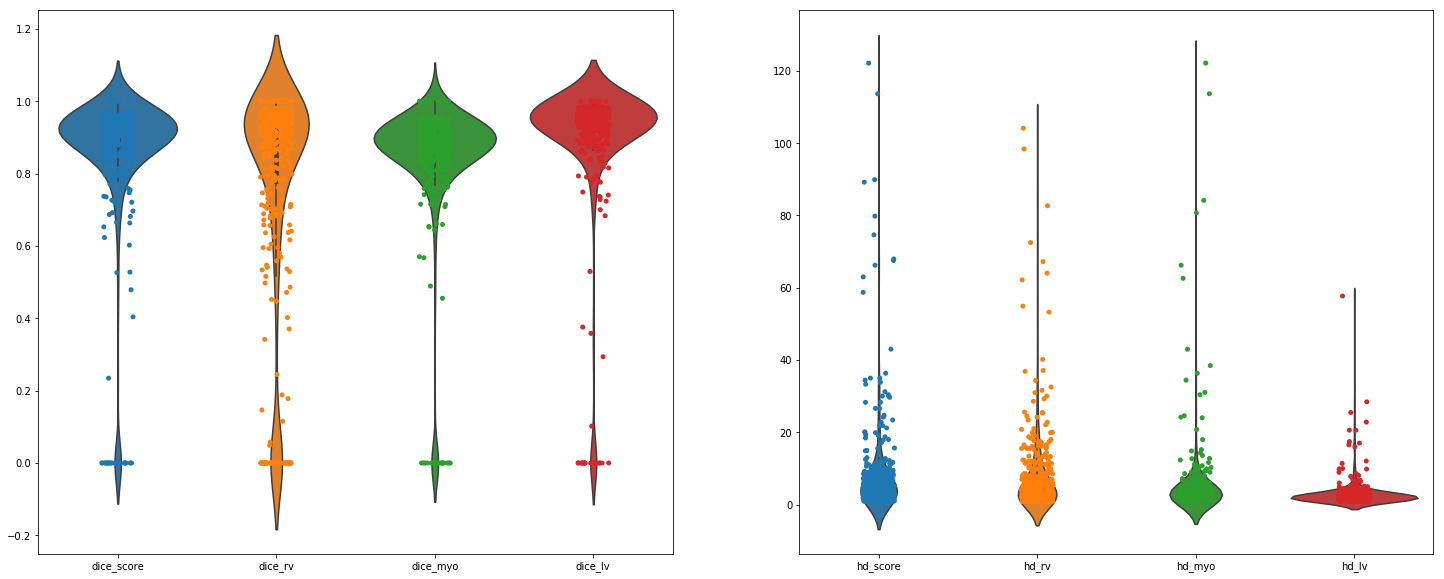

In [15]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10), sharey=False)
cols_dice = [col for col in df.columns if 'dice' in col]
sns.violinplot(data=df[cols_dice],ax=ax1)
sns.stripplot(data=df[cols_dice],ax=ax1)
cols_hd = [col for col in df.columns if 'hd_' in col]
sns.violinplot(data=df[cols_hd],ax=ax2)
sns.stripplot(data=df[cols_hd],ax=ax2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f205f6d9eb8>,
      dtype=object)

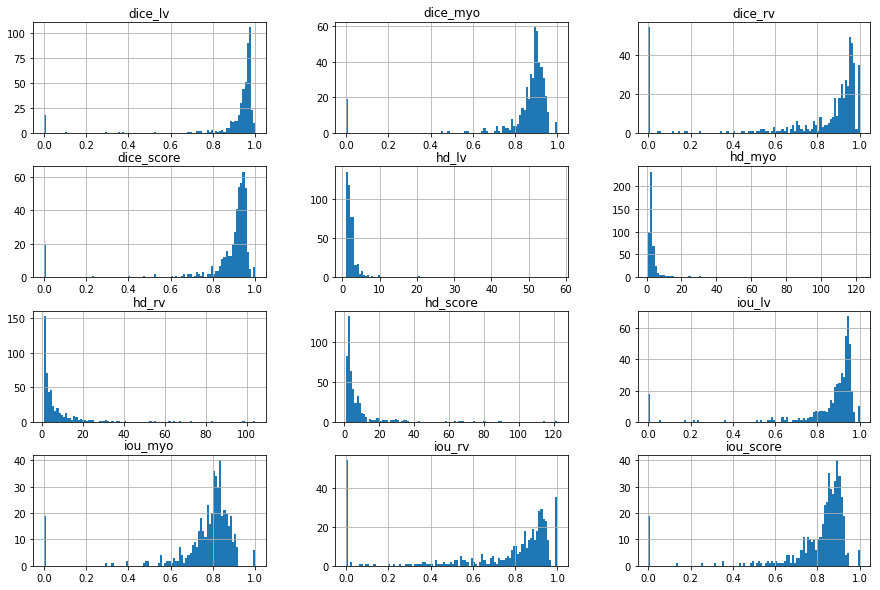

In [9]:
df.hist(bins=100, figsize=(15,10))

# Evaluate with data from crossvalidation dataframe

In [6]:
sorted(glob.glob('reports/configs/2D/kfoldgcn_unsigned/{}/**/**/*.json'.format('GCN'.lower())))

['reports/configs/2D/kfoldgcn_unsigned/gcn/fold0/2020-03-13_16_35/config.json',
 'reports/configs/2D/kfoldgcn_unsigned/gcn/fold1/2020-03-13_17_00/config.json',
 'reports/configs/2D/kfoldgcn_unsigned/gcn/fold2/2020-03-13_17_30/config.json',
 'reports/configs/2D/kfoldgcn_unsigned/gcn/fold3/2020-03-13_18_01/config.json']

In [4]:
# run all evaluations for one training dataset, for the 4 kfold configs , write the evaluation scores in one df
# further evaluation processing will be done with the notebook load_evaluations...
d_t = 'ACDC' # dataset which was used to train the models/create the configs
d_e = 'GCN' # 2nd dataset which sould be used to evaluate the model on
df_path_train = 'data/raw/{}/2D/df_kfold.csv'.format(d_t)
df_path_eval = 'data/raw/{}/2D/df_kfold.csv'.format(d_e)

cfgs = sorted(glob.glob('reports/configs/2D/kfoldgcn_unsigned/{}/**/**/*.json'.format(d_t.lower())))

for fold, c in enumerate(cfgs):
    print('evaluating config: {}'.format(c))
    evaluate_per_area_with_dataframe(fold=fold, c_file=c, dataset=d_e, modality='all', area='all',df_path=df_path_eval, start=True, load_new=True)
    for m in ['train', 'test']:
        evaluate_per_area_with_dataframe(fold=fold, c_file=c, dataset=d_t, modality=m, area='all',df_path=df_path_train, start=True, load_new=False)
    

2020-03-16 10:44:13,853 INFO -------------------- Start --------------------
2020-03-16 10:44:13,853 INFO Working directory: /mnt/data/git/cardio.
2020-03-16 10:44:13,853 INFO Log file: ./logs/2D/kfoldnewgcn_unsigned/acdc/fold0.log
2020-03-16 10:44:13,854 INFO loading trainings history...
2020-03-16 10:44:13,855 INFO No history found! --> reports/history/2D/kfoldnewgcn_unsigned/acdc/fold0/2020-03-10_13_37/history.csv
2020-03-16 10:44:13,855 INFO loading model...


evaluating config: reports/configs/2D/kfoldgcn_unsigned/acdc/fold0/2020-03-10_13_37/config.json


2020-03-16 10:44:17,283 INFO loading model description
2020-03-16 10:44:18,043 INFO loading model weights
2020-03-16 10:44:18,043 INFO model models/2D/kfoldnewgcn_unsigned/acdc/fold0/2020-03-10_13_37/model.json loaded
2020-03-16 10:44:18,044 INFO loading past evaluation scores...
2020-03-16 10:44:18,044 INFO past evaluation scores reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold0/evaluation_score.csv loaded
2020-03-16 10:44:18,044 INFO []
2020-03-16 10:44:18,053 INFO Optimizer: Adam
2020-03-16 10:44:18,121 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold0
2020-03-16 10:44:18,210 INFO Create DataGenerator
2020-03-16 10:44:18,252 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 14344 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:44:18,253 INFO No augmentation


448/448 [==============================] - 23s 52ms/step


2020-03-16 10:44:41,439 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all done
2020-03-16 10:44:41,449 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold0


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387


2020-03-16 10:44:41,482 INFO Optimizer: Adam
2020-03-16 10:44:41,571 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold0
2020-03-16 10:44:41,588 INFO Create DataGenerator
2020-03-16 10:44:41,595 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 1426 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:44:41,597 INFO No augmentation


44/44 [==============================] - 3s 76ms/step


2020-03-16 10:44:44,955 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train done
2020-03-16 10:44:44,957 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold0


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387


2020-03-16 10:44:44,973 INFO Optimizer: Adam
2020-03-16 10:44:45,062 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold0
2020-03-16 10:44:45,079 INFO Create DataGenerator
2020-03-16 10:44:45,081 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 476 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:44:45,082 INFO No augmentation


14/14 [==============================] - 2s 110ms/step


2020-03-16 10:44:46,643 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test done
2020-03-16 10:44:46,645 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold0


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387


2020-03-16 10:44:46,652 INFO -------------------- Start --------------------
2020-03-16 10:44:46,652 INFO Working directory: /mnt/data/git/cardio.
2020-03-16 10:44:46,653 INFO Log file: ./logs/2D/kfoldnewgcn_unsigned/acdc/fold1.log
2020-03-16 10:44:46,653 INFO loading trainings history...
2020-03-16 10:44:46,654 INFO No history found! --> reports/history/2D/kfoldnewgcn_unsigned/acdc/fold1/2020-03-10_13_46/history.csv
2020-03-16 10:44:46,655 INFO loading model...


evaluating config: reports/configs/2D/kfoldgcn_unsigned/acdc/fold1/2020-03-10_13_46/config.json


2020-03-16 10:44:49,795 INFO loading model description
2020-03-16 10:44:50,916 INFO loading model weights
2020-03-16 10:44:50,917 INFO model models/2D/kfoldnewgcn_unsigned/acdc/fold1/2020-03-10_13_46/model.json loaded
2020-03-16 10:44:50,917 INFO loading past evaluation scores...
2020-03-16 10:44:50,917 INFO past evaluation scores reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold1/evaluation_score.csv loaded
2020-03-16 10:44:50,918 INFO []
2020-03-16 10:44:50,927 INFO Optimizer: Adam
2020-03-16 10:44:51,122 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold1
2020-03-16 10:44:51,208 INFO Create DataGenerator
2020-03-16 10:44:51,251 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 14344 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:44:51,251 INFO No augmentation


448/448 [==============================] - 22s 50ms/step


2020-03-16 10:45:13,528 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all done
2020-03-16 10:45:13,533 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold1


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878


2020-03-16 10:45:13,563 INFO Optimizer: Adam
2020-03-16 10:45:13,646 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold1
2020-03-16 10:45:13,663 INFO Create DataGenerator
2020-03-16 10:45:13,670 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 1422 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:45:13,670 INFO No augmentation


44/44 [==============================] - 4s 83ms/step


2020-03-16 10:45:17,334 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train done
2020-03-16 10:45:17,339 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold1


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878


2020-03-16 10:45:17,384 INFO Optimizer: Adam
2020-03-16 10:45:17,470 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold1
2020-03-16 10:45:17,485 INFO Create DataGenerator
2020-03-16 10:45:17,487 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 480 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:45:17,487 INFO No augmentation


15/15 [==============================] - 2s 131ms/step


2020-03-16 10:45:19,469 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test done
2020-03-16 10:45:19,471 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold1


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test,-0.895681,0.904408,0.532451,0.882389,0.947845,0.882784
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878


2020-03-16 10:45:19,479 INFO -------------------- Start --------------------
2020-03-16 10:45:19,479 INFO Working directory: /mnt/data/git/cardio.
2020-03-16 10:45:19,479 INFO Log file: ./logs/2D/kfoldnewgcn_unsigned/acdc/fold2.log
2020-03-16 10:45:19,479 INFO loading trainings history...
2020-03-16 10:45:19,481 INFO No history found! --> reports/history/2D/kfoldnewgcn_unsigned/acdc/fold2/2020-03-10_13_59/history.csv
2020-03-16 10:45:19,481 INFO loading model...


evaluating config: reports/configs/2D/kfoldgcn_unsigned/acdc/fold2/2020-03-10_13_59/config.json


2020-03-16 10:45:22,676 INFO loading model description
2020-03-16 10:45:24,196 INFO loading model weights
2020-03-16 10:45:24,197 INFO model models/2D/kfoldnewgcn_unsigned/acdc/fold2/2020-03-10_13_59/model.json loaded
2020-03-16 10:45:24,197 INFO loading past evaluation scores...
2020-03-16 10:45:24,198 INFO past evaluation scores reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold2/evaluation_score.csv loaded
2020-03-16 10:45:24,198 INFO []
2020-03-16 10:45:24,207 INFO Optimizer: Adam
2020-03-16 10:45:24,282 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold2
2020-03-16 10:45:24,368 INFO Create DataGenerator
2020-03-16 10:45:24,410 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 14344 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:45:24,411 INFO No augmentation


448/448 [==============================] - 22s 49ms/step


2020-03-16 10:45:46,246 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold2_GCN_all_2_all done
2020-03-16 10:45:46,247 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold2


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test,-0.895681,0.904408,0.532451,0.882389,0.947845,0.882784
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878
2D/kfoldnewgcn_unsigned/acdc/fold2_GCN_all_2_all,-0.723094,0.749788,0.423212,0.677395,0.811301,0.747347


2020-03-16 10:45:46,266 INFO Optimizer: Adam
2020-03-16 10:45:46,341 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold2
2020-03-16 10:45:46,354 INFO Create DataGenerator
2020-03-16 10:45:46,359 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 1452 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:45:46,360 INFO No augmentation


45/45 [==============================] - 4s 89ms/step


2020-03-16 10:45:50,424 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_train done
2020-03-16 10:45:50,426 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold2


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test,-0.895681,0.904408,0.532451,0.882389,0.947845,0.882784
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_train,-0.917937,0.924030,0.433456,0.892433,0.952879,0.926855
2D/kfoldnewgcn_unsigned/acdc/fold2_GCN_all_2_all,-0.723094,0.749788,0.423212,0.677395,0.811301,0.747347


2020-03-16 10:45:50,444 INFO Optimizer: Adam
2020-03-16 10:45:50,534 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold2
2020-03-16 10:45:50,548 INFO Create DataGenerator
2020-03-16 10:45:50,550 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 450 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:45:50,551 INFO No augmentation


14/14 [==============================] - 2s 162ms/step


2020-03-16 10:45:52,831 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_test done
2020-03-16 10:45:52,832 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold2


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test,-0.895681,0.904408,0.532451,0.882389,0.947845,0.882784
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_test,-0.897041,0.905371,0.432355,0.875152,0.945011,0.895183
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_train,-0.917937,0.924030,0.433456,0.892433,0.952879,0.926855
2D/kfoldnewgcn_unsigned/acdc/fold2_GCN_all_2_all,-0.723094,0.749788,0.423212,0.677395,0.811301,0.747347


2020-03-16 10:45:52,839 INFO -------------------- Start --------------------
2020-03-16 10:45:52,839 INFO Working directory: /mnt/data/git/cardio.
2020-03-16 10:45:52,840 INFO Log file: ./logs/2D/kfoldnewgcn_unsigned/acdc/fold3.log
2020-03-16 10:45:52,840 INFO loading trainings history...
2020-03-16 10:45:52,841 INFO No history found! --> reports/history/2D/kfoldnewgcn_unsigned/acdc/fold3/2020-03-10_14_08/history.csv
2020-03-16 10:45:52,841 INFO loading model...


evaluating config: reports/configs/2D/kfoldgcn_unsigned/acdc/fold3/2020-03-10_14_08/config.json


2020-03-16 10:45:56,212 INFO loading model description
2020-03-16 10:45:58,217 INFO loading model weights
2020-03-16 10:45:58,218 INFO model models/2D/kfoldnewgcn_unsigned/acdc/fold3/2020-03-10_14_08/model.json loaded
2020-03-16 10:45:58,218 INFO loading past evaluation scores...
2020-03-16 10:45:58,218 INFO past evaluation scores reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold3/evaluation_score.csv loaded
2020-03-16 10:45:58,219 INFO []
2020-03-16 10:45:58,229 INFO Optimizer: Adam
2020-03-16 10:45:58,300 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold3
2020-03-16 10:45:58,387 INFO Create DataGenerator
2020-03-16 10:45:58,430 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 14344 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:45:58,431 INFO No augmentation


448/448 [==============================] - 22s 50ms/step


2020-03-16 10:46:20,928 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold3_GCN_all_3_all done
2020-03-16 10:46:20,932 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold3


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test,-0.895681,0.904408,0.532451,0.882389,0.947845,0.882784
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_test,-0.897041,0.905371,0.432355,0.875152,0.945011,0.895183
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_train,-0.917937,0.924030,0.433456,0.892433,0.952879,0.926855
2D/kfoldnewgcn_unsigned/acdc/fold2_GCN_all_2_all,-0.723094,0.749788,0.423212,0.677395,0.811301,0.747347


2020-03-16 10:46:20,952 INFO Optimizer: Adam
2020-03-16 10:46:21,046 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold3
2020-03-16 10:46:21,064 INFO Create DataGenerator
2020-03-16 10:46:21,070 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 1406 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:46:21,071 INFO No augmentation


43/43 [==============================] - 4s 103ms/step


2020-03-16 10:46:25,487 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold3_ACDC_all_3_train done
2020-03-16 10:46:25,491 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold3


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test,-0.895681,0.904408,0.532451,0.882389,0.947845,0.882784
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_test,-0.897041,0.905371,0.432355,0.875152,0.945011,0.895183
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_train,-0.917937,0.924030,0.433456,0.892433,0.952879,0.926855
2D/kfoldnewgcn_unsigned/acdc/fold2_GCN_all_2_all,-0.723094,0.749788,0.423212,0.677395,0.811301,0.747347


2020-03-16 10:46:25,541 INFO Optimizer: Adam
2020-03-16 10:46:25,619 INFO Experiment: 2D/kfoldnewgcn_unsigned/acdc/fold3
2020-03-16 10:46:25,634 INFO Create DataGenerator
2020-03-16 10:46:25,636 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 32
 Scaler: MinMax
 Images: 496 
 Augment_grid: False 
 Thread workers: 32
2020-03-16 10:46:25,636 INFO No augmentation


15/15 [==============================] - 3s 193ms/step


2020-03-16 10:46:28,540 INFO evaluation for: 2D/kfoldnewgcn_unsigned/acdc/fold3_ACDC_all_3_test done
2020-03-16 10:46:28,548 INFO Scores saved to: reports/evaluation/2D/kfoldnewgcn_unsigned/acdc/fold3


,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test,-0.895681,0.904408,0.532451,0.882389,0.947845,0.882784
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_test,-0.897041,0.905371,0.432355,0.875152,0.945011,0.895183
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_train,-0.917937,0.924030,0.433456,0.892433,0.952879,0.926855
2D/kfoldnewgcn_unsigned/acdc/fold2_GCN_all_2_all,-0.723094,0.749788,0.423212,0.677395,0.811301,0.747347


In [5]:
evaluation_score

,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_test,-0.897860,0.906746,0.686452,0.877627,0.945875,0.896579
2D/kfoldnewgcn_unsigned/acdc/fold0_ACDC_all_0_train,-0.916719,0.922332,0.688687,0.889834,0.953763,0.924028
2D/kfoldnewgcn_unsigned/acdc/fold0_GCN_all_0_all,-0.759262,0.782089,0.674227,0.717848,0.872969,0.757387
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_test,-0.895681,0.904408,0.532451,0.882389,0.947845,0.882784
2D/kfoldnewgcn_unsigned/acdc/fold1_ACDC_all_1_train,-0.924866,0.929928,0.534815,0.898157,0.959471,0.931998
2D/kfoldnewgcn_unsigned/acdc/fold1_GCN_all_1_all,-0.769735,0.792129,0.536026,0.738664,0.884873,0.759878
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_test,-0.897041,0.905371,0.432355,0.875152,0.945011,0.895183
2D/kfoldnewgcn_unsigned/acdc/fold2_ACDC_all_2_train,-0.917937,0.924030,0.433456,0.892433,0.952879,0.926855
2D/kfoldnewgcn_unsigned/acdc/fold2_GCN_all_2_all,-0.723094,0.749788,0.423212,0.677395,0.811301,0.747347


In [6]:
evaluation_score.to_csv(os.path.join('reports/evaluation/2D/kfoldgcn_unsigned/acdc/','evaluation_score.csv'))

In [108]:
evaluation_score = evaluation_score.drop(['2D/new_kfold/tetra_acdc_all_3_test', 
                                          '2D/new_kfold/tetraacdc_all_0_all', 
                                          '2D/new_kfold/tetraacdc_all_0_test', 
                                          '2D/new_kfold/tetraacdc_all_0_train', 
                                          '2D/new_kfold/tetratetra_all_0_all',
                                         '2D/new_kfold/tetratetra_all_0_test',
                                         '2D/new_kfold/tetratetra_all_0_train',
                                         '2D/new_kfold/tetratetra_all_1_test'], axis=0)

In [119]:
evaluation_score.sort_index()

,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/new_kfold/tetra_acdc_all_0_all,-0.885370,0.767889,0.931785,0.712777,0.854131,0.735502
2D/new_kfold/tetra_acdc_all_1_all,-0.621384,0.784638,0.713787,0.726248,0.865731,0.760017
2D/new_kfold/tetra_acdc_all_2_all,-0.720196,0.757786,0.799732,0.705970,0.827990,0.741156
2D/new_kfold/tetra_acdc_all_3_all,-0.446907,0.744284,0.567579,0.700095,0.845575,0.699027
2D/new_kfold/tetra_tetra_all_0_test,-0.910120,0.856755,0.945288,0.810466,0.922502,0.839449
2D/new_kfold/tetra_tetra_all_0_train,-0.920406,0.892434,0.947908,0.827190,0.940618,0.894960
2D/new_kfold/tetra_tetra_all_1_test,-0.689603,0.857490,0.761231,0.803209,0.922690,0.845634
2D/new_kfold/tetra_tetra_all_1_train,-0.694692,0.888201,0.762024,0.825066,0.936556,0.889376
2D/new_kfold/tetra_tetra_all_2_test,-0.718366,0.855870,0.791200,0.790525,0.923077,0.848087


In [120]:
# minor index cleaning, newer entries should already use this format
evaluation_score.index = evaluation_score.index.str.replace('tetrat', 'tetra_t')
evaluation_score.index = evaluation_score.index.str.replace('tetraa', 'tetra_a')
evaluation_score.index = evaluation_score.index.str.replace('acdca', 'acdc_a')
evaluation_score.index = evaluation_score.index.str.replace('acdct', 'acdc_t')
evaluation_score.to_csv('reports/evaluation/2D/new_kfold/tetra/evaluation_score.csv')

In [15]:
evaluation_score.index

Index(['2D/new_kfold/acdc_acdc_all_0_test',
       '2D/new_kfold/acdc_acdc_all_0_train',
       '2D/new_kfold/acdc_acdc_all_1_test',
       '2D/new_kfold/acdc_acdc_all_1_train',
       '2D/new_kfold/acdc_acdc_all_2_test',
       '2D/new_kfold/acdc_acdc_all_2_train',
       '2D/new_kfold/acdc_acdc_all_3_test',
       '2D/new_kfold/acdc_acdc_all_3_train',
       '2D/new_kfold/acdc_tetra_all_0_all',
       '2D/new_kfold/acdc_tetra_all_1_all',
       '2D/new_kfold/acdc_tetra_all_2_all',
       '2D/new_kfold/acdc_tetra_all_3_all',
       '2D/new_kfold/tetra_acdc_all_0_all',
       '2D/new_kfold/tetra_acdc_all_0_test',
       '2D/new_kfold/tetra_acdc_all_0_train',
       '2D/new_kfold/tetra_tetra_all_0_all',
       '2D/new_kfold/tetra_tetra_all_0_test',
       '2D/new_kfold/tetra_tetra_all_0_train',
       '2D/new_kfold/tetra_tetra_all_1_test'],
      dtype='object', name='Evaluation')

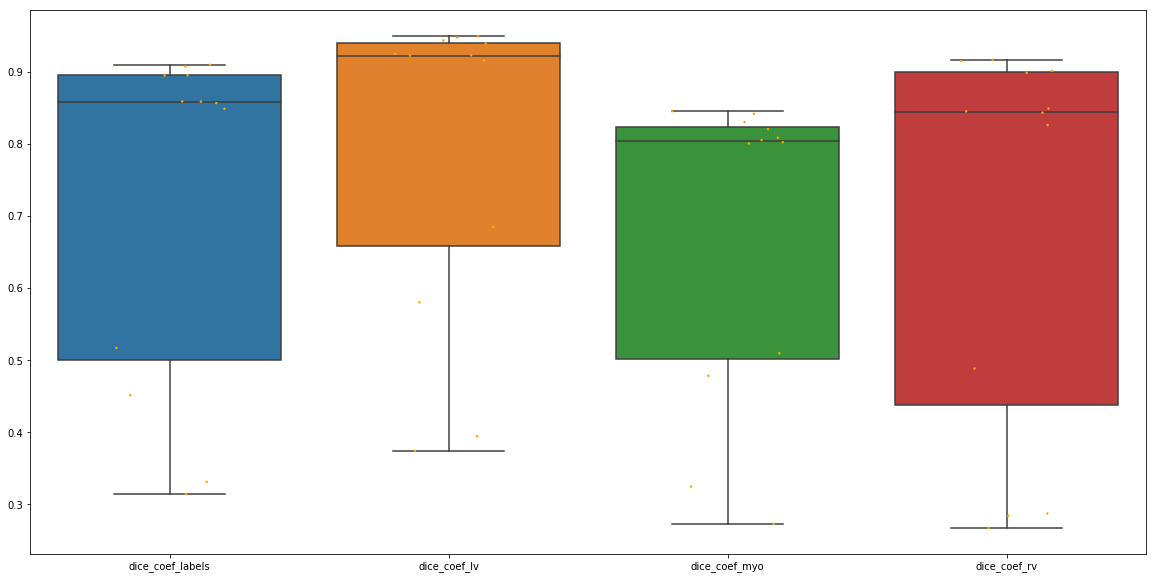

In [79]:
cols = [col for col in df_tableau.columns if 'dice' in col]
df = df_tableau[df_tableau['Training dataset'] == 'tetra'][cols]

fig, ax2 = plt.subplots(figsize=(20,10))
ax2 = sns.boxplot(data=df,ax=ax2)
#ax2 = sns.swarmplot(data=df, color=".25",ax=ax2)
ax2 = sns.stripplot(data=df, color="orange", jitter=0.2, size=2.5, ax=ax2)

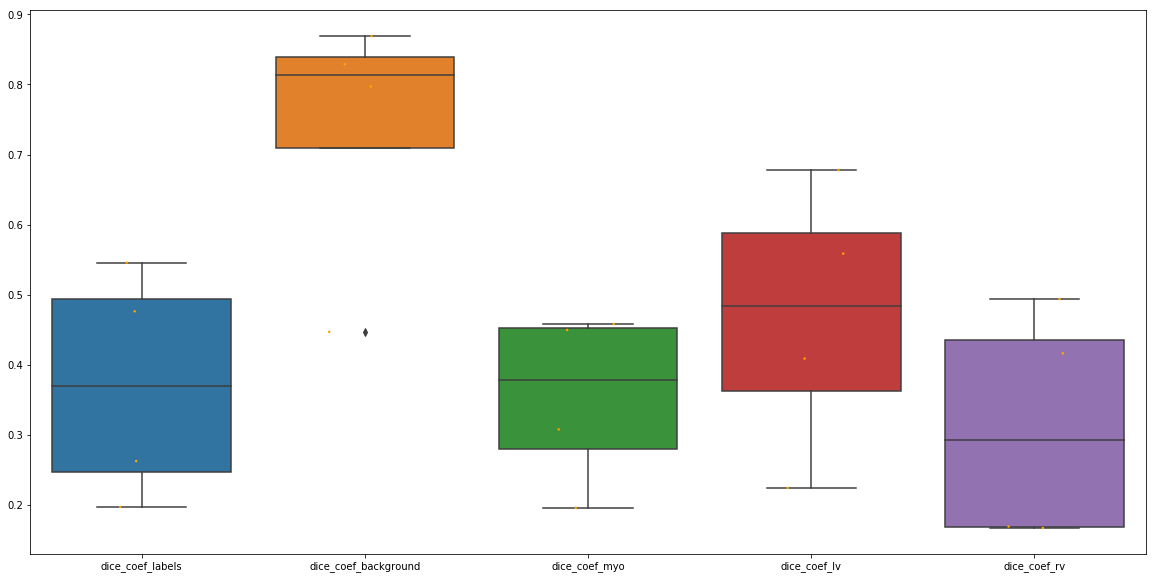

In [11]:
# plot the crossvalidated ACDC scores
fig, ax2 = plt.subplots(figsize=(20,10))
df = evaluation_score.loc[:'2D/unet_tetra_spacing1_batch32_drop04_batchnorm_minmax_kfold4acdc_all_3_all', evaluation_score.columns != 'loss']
ax2 = sns.boxplot(data=df, ax=ax2)
#ax2 = sns.swarmplot(data=df, color=".25",ax=ax2)
ax2 = sns.stripplot(data=df, color="orange", jitter=0.2, size=2.5, ax=ax2)

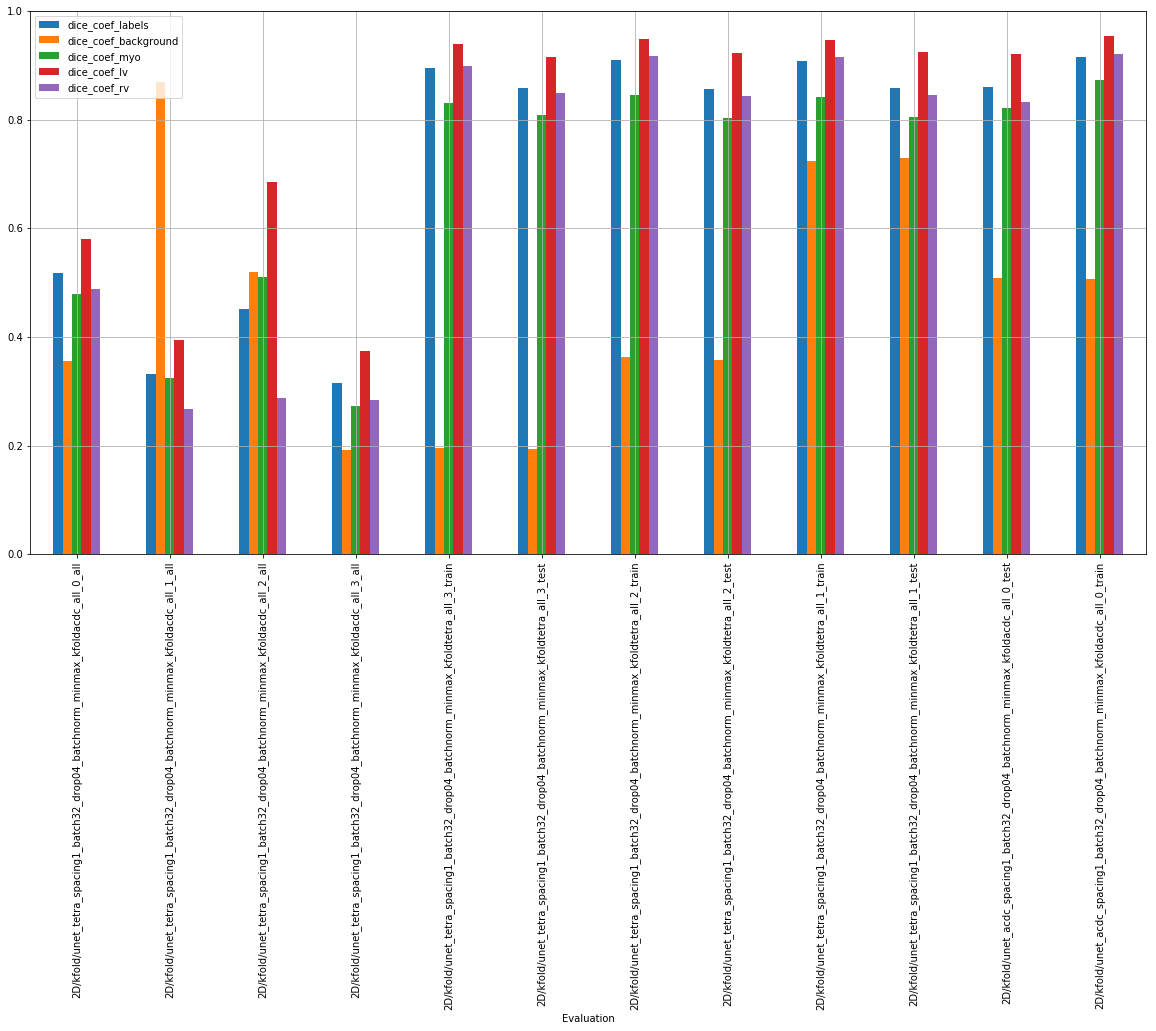

In [11]:
fix, ax = plt.subplots(figsize=(20,10))
evaluation_score.loc[:, evaluation_score.columns != 'loss'].plot(kind='bar', ax = ax, grid=True)

# predict on data from the dataframes

In [23]:
@interact
def evaluate_per_label_with_path(path='data/raw/GCN/2D/test', dataset=['tetra', 'acdc'],start=False):
    
    # calculate per image and per label scores (dc and jc) for a given directory
    
    # get x, y numpy from Datagenerator and predict with model
    if start:
    # load data sliced

        path_as_string = path.replace('/','_')
        
        
        X_test = glob.glob('data/raw/GCN/2D/test/*img.nrrd')
        Y_test = glob.glob('data/raw/GCN/2D/test/*msk.nrrd')
        logging.info('Files registered: {}'.format(len(X_test)))
        logging.info('Files registered: {}'.format(len(Y_test)))
    
        config['SHUFFLE'] = False
        
        # generate DataGenerator for slice extraction
        test_generator = DataGenerator(X_test, Y_test, config)
        logging.info('Datagenerator created')

        y_ = []
        pred_ = []
        n_batches = len(test_generator)
        logging.info('load and predict {} batches'.format(n_batches))

        pred = model.predict_generator(test_generator)
        
        x_ = []
        y_ = []
        for gcn_batch in test_generator:
            x_.append(gcn_batch[0])
            y_.append(gcn_batch[1])
        x = np.concatenate(x_, axis=0)
        y = np.concatenate(x_, axis=0)
        
        logging.info('Model prediction done')

        globals()['x'] = x
        globals()['y'] = y
        globals()['pred'] = pred
        df = pd.DataFrame(columns=['X_path', 'Y_path'])
        # cut the last files
        df['X_path_full'] = [f_name for f_name in X_test][:len(y)]
        df['Y_path_full'] = [f_name for f_name in Y_test][:len(y)]
        df['X_path'] = [os.path.basename(f_name) for f_name in X_test][:len(y)]
        df['Y_path'] = [os.path.basename(f_name) for f_name in Y_test][:len(y)]

        
        from medpy.metric.binary import hd
        hds = []
        ious = []
        dcs = []
        logging.info('calculate per image and per label scores')
        for p_, y_ in zip(pred, y):
            dcs.append(calc_per_label_scores(p_,y_,dice_numpy))
            ious.append(calc_per_label_scores(p_,y_,jc))
            hds.append(calc_per_label_scores(p_,y_,hd))
        
        dcs, dc_rv, dc_myo, dc_lv = zip(*dcs)
        iou, iou_rv, iou_myo, iou_lv = zip(*ious)
        globals()['hds'] = hds


        df['dice_score'] = dcs
        df['dice_rv'] = dc_rv
        df['dice_myo'] = dc_myo
        df['dice_lv'] = dc_lv
        df['iou_score'] = iou
        df['iou_rv'] = iou_rv
        df['iou_myo'] = iou_myo
        df['iou_lv'] = iou_lv

        #del y, pred
        globals()['y']=y
        globals()['pred']=pred
        logging.info('dataframe created')
        export_path = os.path.join('reports/evaluation', config['EXPERIMENT'])
        ensure_dir(export_path)
        df.to_csv(os.path.join(export_path, 'scores_per_image_' + path_as_string + '.csv'))
        
        globals()['df_' + path_as_string] = df
        logging.info('{} created'.format('df_' + path_as_string))

interactive(children=(Text(value='data/raw/GCN/2D/test', description='path'), Dropdown(description='dataset', …

In [21]:
glob.glob('data/raw/GCN/2D/test/*img.nrrd')

['data/raw/GCN/2D/test/0160-84R7FQH3-2007-03-16__t9_z4_img.nrrd',
 'data/raw/GCN/2D/test/0578-U4RLC7PU-2005-06-02__t5_z13_img.nrrd',
 'data/raw/GCN/2D/test/0129-5YX47QXL-2006-10-13__t0_z6_img.nrrd',
 'data/raw/GCN/2D/test/0188-9HQPRPDH-2006-01-31__t5_z9_img.nrrd',
 'data/raw/GCN/2D/test/0244-CK8JTQLW-2005-08-08__t3_z10_img.nrrd',
 'data/raw/GCN/2D/test/0244-CK8JTQLW-2005-08-08__t3_z13_img.nrrd',
 'data/raw/GCN/2D/test/0242-CHGJW3CL-2006-11-24__t24_z8_img.nrrd',
 'data/raw/GCN/2D/test/0244-CK8JTQLW-2005-08-08__t3_z2_img.nrrd',
 'data/raw/GCN/2D/test/0578-U4RLC7PU-2005-06-02__t0_z6_img.nrrd',
 'data/raw/GCN/2D/test/0578-U4RLC7PU-2005-06-02__t10_z8_img.nrrd',
 'data/raw/GCN/2D/test/0258-CTFRR3KT-2006-08-29__t0_z13_img.nrrd',
 'data/raw/GCN/2D/test/0318-FHQU30DQ-2005-05-10__t11_z12_img.nrrd',
 'data/raw/GCN/2D/test/0428-LANRRLP0-2006-02-23__t15_z10_img.nrrd',
 'data/raw/GCN/2D/test/0237-CEAHC3DZ-2006-08-21__t19_z4_img.nrrd',
 'data/raw/GCN/2D/test/0129-5YX47QXL-2006-10-13__t6_z9_img.nrrd',

In [23]:
path = 'data/raw/ACDC/2D/val'
X_test, Y_test = get_img_msk_files_from_split_dir(path=path)
logging.info('Files registered: {}'.format(len(X_test)))
# generate DataGenerator for slice extraction
config['SHUFFLE'] = False
test_generator = DataGenerator2D(X_test, Y_test, config)
pred_reshaped = pred.reshape((27, 16,224,224,4))
@interact
def show_datagenerator_interact(batch = (0,len(test_generator)), img=(0,config['BATCHSIZE'])):
    
    x, y = test_generator.__getitem__(batch)
    show_slice_transparent(x[img], y[img])
    show_slice_transparent(x[img], pred_reshaped[batch][img])

2019-07-31 12:45:46,161 INFO Files registered: 434
2019-07-31 12:45:46,161 INFO Create DataGenerator
2019-07-31 12:45:46,161 INFO No augmentation


interactive(children=(IntSlider(value=13, description='batch', max=27), IntSlider(value=8, description='img', …

In [19]:
path = 'data/raw/tetra/2D/val'
X_test, Y_test = get_img_msk_files_from_split_dir(path=path)
logging.info('Files registered: {}'.format(len(X_test)))
# generate DataGenerator for slice extraction
config['SHUFFLE'] = False
test_generator = DataGenerator2D(X_test, Y_test, config)

@interact
def show_datagenerator_interact(batch = (0,len(test_generator)), img=(0,config['BATCHSIZE'])):
    
    x, y = test_generator.__getitem__(batch)
    show_slice_transparent(x[img], y[img])

2019-07-31 12:37:03,686 INFO Files registered: 1870
2019-07-31 12:37:03,686 INFO Create DataGenerator
2019-07-31 12:37:03,686 INFO No augmentation


interactive(children=(IntSlider(value=58, description='batch', max=116), IntSlider(value=8, description='img',…

In [14]:
@interact
def show_predictions_interact(img=(0,pred.shape[0])):
    show_slice(mask=pred[img])
    show_slice(mask=y[img])

interactive(children=(IntSlider(value=216, description='img', max=432), Output()), _dom_classes=('widget-inter…

In [22]:
# plot per image score distributiuon
@interact
def plot_per_image_scores(
        df_key=[key for key, value in globals().items() if 'df' in key],
        plot_type=['kde', 'hist', 'box'],
        lower=0.0,
        upper=1.0,
        filter_columns=''):

    try:
        %matplotlib inline

        df = globals()[df_key]
        #df = df.dropna()
        #df = df.apply(lambda col:pd.to_numeric(col, errors='coerce'))

        args = {
            'kind': plot_type,
            'figsize': (20, 10),
            'legend': True,
            'grid': True,
            'stacked': False,
            'title': 'Per Image Score'
        }
        if args['kind'] == 'hist':
            args['bins'] = 200
            
        # filter by column name
        if filter_columns != '':
            df = df.filter(like=filter_columns, axis=1)
        else: # if no filter given filter only float columns to make lower/upper filtering possible
            df = df.loc[:, df.dtypes == 'float64']
        
        # filter all rows with values smaller than lower or bigger than upper
        cols = df.columns
        # get all rows between lower and upper, boundaries included
        df = df[df[cols] >= lower]
        df = df[df[cols] <= upper]
        #df.dropna()
        fig, ax1 = plt.subplots()
        df.plot(**args, ax = ax1)
        fig, ax2 = plt.subplots(figsize=(20,10))
        ax2 = sns.boxplot(data=df, ax=ax2)
        #ax2 = sns.swarmplot(data=df, color=".25",ax=ax2)
        ax2 = sns.stripplot(data=df, color="orange", jitter=0.2, size=2.5, ax=ax2)

        plt.title("per image scores ", loc="center")
        plt.xticks(rotation=45)

    except Exception as e:
        print(str(e))
        return df.head()

interactive(children=(Dropdown(description='df_key', options=('df_history', 'df_data_raw_ACDC_2D_val'), value=…

In [69]:
df_data_raw_tetra_2D_test.head()

,X_path,Y_path,X_path_full,Y_path_full,dice_score,dice_rv,dice_myo,dice_lv,iou_score,iou_rv,iou_myo,iou_lv
0,0019-1EMMCVKN-2006-06-29__t13_z0_img.nrrd,0019-1EMMCVKN-2006-06-29__t13_z0_msk.nrrd,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,0.803666,0.000000,0.000000,0.000000,0.671774,0.000000,0.000000,0.000000
1,0019-1EMMCVKN-2006-06-29__t13_z10_img.nrrd,0019-1EMMCVKN-2006-06-29__t13_z10_msk.nrrd,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,0.851020,0.000000,1.000000,1.000000,0.740675,0.000000,1.000000,1.000000
2,0019-1EMMCVKN-2006-06-29__t13_z11_img.nrrd,0019-1EMMCVKN-2006-06-29__t13_z11_msk.nrrd,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,0.861259,0.000000,1.000000,1.000000,0.756325,0.000000,1.000000,1.000000
3,0019-1EMMCVKN-2006-06-29__t13_z1_img.nrrd,0019-1EMMCVKN-2006-06-29__t13_z1_msk.nrrd,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,0.844629,0.909008,0.726525,0.929667,0.731046,0.833195,0.570506,0.868577
4,0019-1EMMCVKN-2006-06-29__t13_z2_img.nrrd,0019-1EMMCVKN-2006-06-29__t13_z2_msk.nrrd,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,data/raw/tetra/2D/test\0019-1EMMCVKN-2006-06-2...,0.854918,0.925353,0.692699,0.957672,0.746600,0.861075,0.529870,0.918782


In [62]:
import SimpleITK as sitk
mask1 = sitk.GetArrayFromImage(sitk.ReadImage('data/raw/tetra/2D/val/0055-2V8HJLHN-2005-08-30__t0_z5_msk.nrrd'))
mask2 = sitk.GetArrayFromImage(sitk.ReadImage('data/raw/tetra/2D/val/0055-2V8HJLHN-2005-08-30__t0_z6_msk.nrrd'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000005B1345C0>,
      dtype=object)

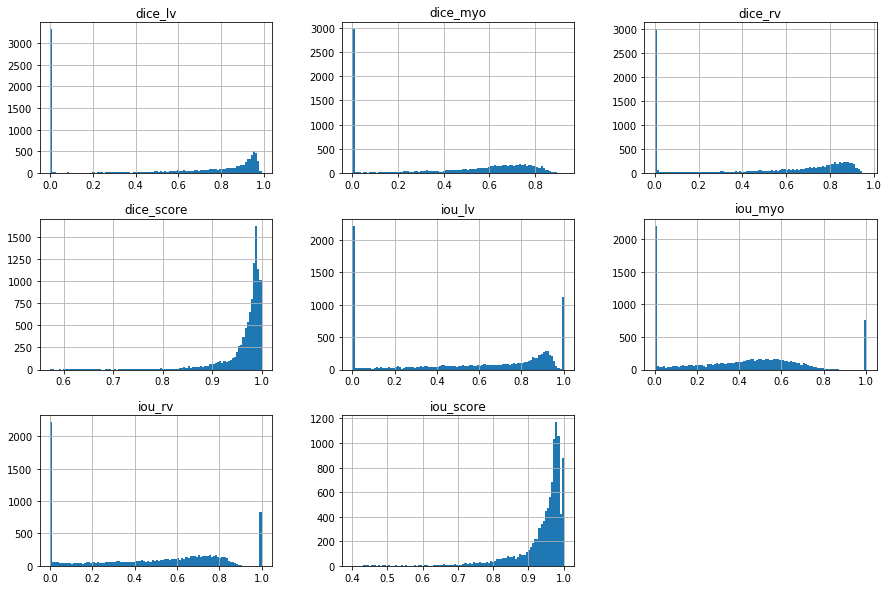

In [43]:
#plot one histogram per score
df_data_raw_tetra_2D_train.hist(bins=100, figsize=(15,10))

In [44]:
df_data_raw_tetra_2D_test.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 0 to 1846
Data columns (total 12 columns):
X_path         1847 non-null object
Y_path         1847 non-null object
X_path_full    1847 non-null object
Y_path_full    1847 non-null object
dice_score     1847 non-null float64
dice_rv        1847 non-null float64
dice_myo       1847 non-null float64
dice_lv        1847 non-null float64
iou_score      1847 non-null float64
iou_rv         1847 non-null float64
iou_myo        1847 non-null float64
iou_lv         1847 non-null float64
dtypes: float64(8), object(4)
memory usage: 187.6+ KB


In [ ]:
#df_data_processed_train[df_data_processed_train['dice_score']<=0].to_csv(os.path.join(os.path.join('reports/evaluation', EXPERIMENT),'zero_dice'+ 'data_processed_train.csv'))

#df_data_processed_train[df_data_processed_train['dice_myo']<=0].to_csv(os.path.join(os.path.join('reports/evaluation', EXPERIMENT),'zero_dice_myo_data_processed_train.csv'))

#df_data_processed_train[df_data_processed_train['dice_lv']<=0].to_csv(os.path.join(os.path.join('reports/evaluation', EXPERIMENT),'zero_dice_lv_data_processed_train.csv'))

#df_data_processed_train[df_data_processed_train['dice_rv']<=0].to_csv(os.path.join(os.path.join('reports/evaluation', EXPERIMENT),'zero_dice_rv_data_processed_train.csv'))

In [44]:
def convert_channel_to_label(arr, flatten = False):
    """
    Converts a numpy matrix from binary channel type to label based style
    keeps channels
    """
    channel_arr = arr.copy()
    label_arr = np.zeros(channel_arr.shape)

    logging.info(label_arr.shape)
    labels = [1,2,3] # we dont need to transform the first channel/background, array is zero initialized
    
    # traverse through the channels
    for label, i in zip(labels, range(label_arr.shape[-1]-1)):
        label_arr[...,i][(channel_arr[...,i] > 0.5)] = label
        
    if flatten:
        label_arr = label_arr.flatten()
        
    return label_arr.astype(np.uint16)
    

2020-01-25 19:28:57,259 INFO (456, 224, 224, 4)
2020-01-25 19:28:57,624 INFO (456, 224, 224, 4)


Normalized confusion matrix
[[9.94644109e-01 4.47322016e-03 3.47351062e-04 5.35319742e-04]
 [9.99998569e-01 1.43069063e-06 0.00000000e+00 0.00000000e+00]
 [7.01655169e-02 0.00000000e+00 9.29834483e-01 0.00000000e+00]
 [1.02264548e-01 0.00000000e+00 0.00000000e+00 8.97735452e-01]]


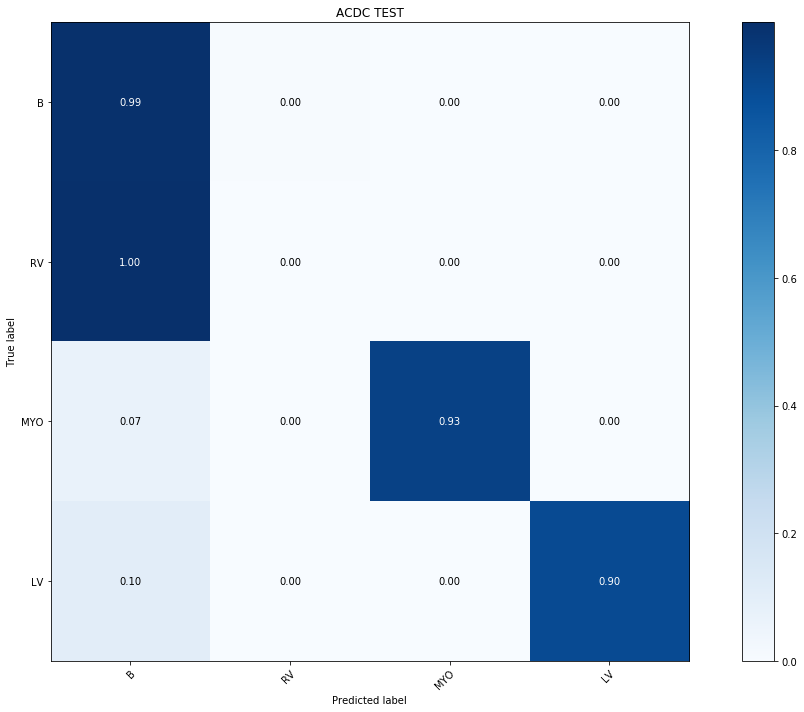

In [45]:
# trained with tetra, tested with tetra 2d test dataset
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
#c = confusion_matrix(pred_b_one_hot, y_one_hot)

plot_confusion_matrix(convert_channel_to_label(y, flatten=True), convert_channel_to_label(pred, flatten=True), ['B','RV', 'MYO', 'LV'], True, 'ACDC TEST')

2019-07-11 17:53:38,753 INFO (434, 256, 256, 4)
2019-07-11 17:53:40,461 INFO (434, 256, 256, 4)


Normalized confusion matrix
[[0.98694981 0.00847897 0.00323067 0.00134055]
 [0.36868978 0.63131022 0.         0.        ]
 [0.13230101 0.         0.86769899 0.        ]
 [0.32580014 0.         0.         0.67419986]]


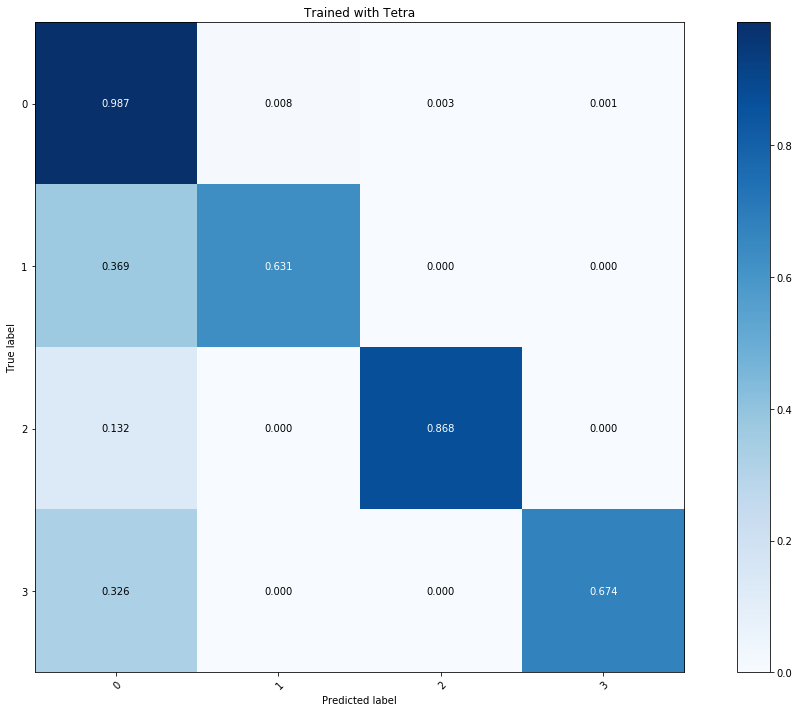

In [79]:
# trained with tetra, tested with acdc 2d test dataset
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
#c = confusion_matrix(pred_b_one_hot, y_one_hot)

plot_confusion_matrix(convert_channel_to_label(y, flatten=True), convert_channel_to_label(pred, flatten=True), [0,1,2,3], True, 'Trained with Tetra')

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    clases = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [85]:
%timeit x_stacked = np.stack(x_)

683 ms ± 93.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%timeit  x_stacked = np.array(x_)

642 ms ± 58.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Tests with Hausdorff distances

label: 0, HD scipy: (5.5677643628300215, 94, 178)
label: 0, HD medpy: 0.0
label: 1, HD scipy: (2.0, 169, 167)
label: 1, HD medpy: 0.0
label: 2, HD scipy: (2.449489742783178, 115, 115)
label: 2, HD medpy: 0.0
label: 3, HD scipy: (1.7320508075688772, 115, 115)
label: 3, HD medpy: 0.0


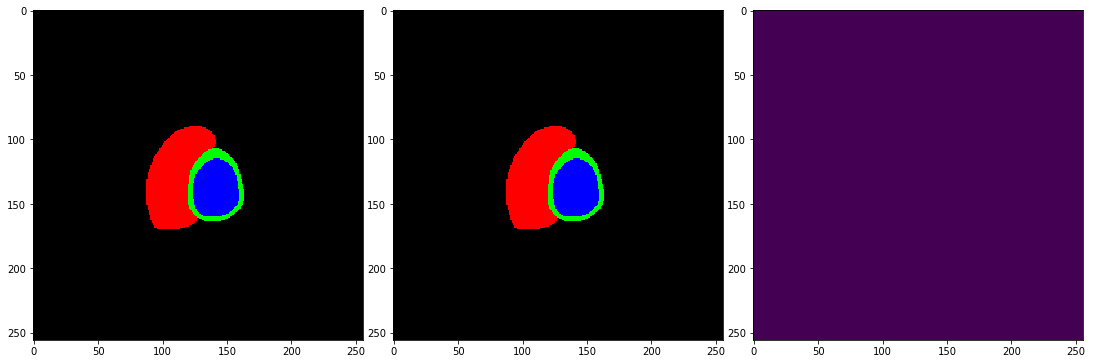

2019-07-14 11:54:31,856 INFO Image-shape: (256, 256)
2019-07-14 11:54:31,856 INFO Image data points: 0
2019-07-14 11:54:31,856 INFO Image mean: 0.000
2019-07-14 11:54:31,856 INFO Image max: 0.000
2019-07-14 11:54:31,856 INFO Image min: 0.000
2019-07-14 11:54:31,856 INFO Mask-shape: (256, 256, 3)
2019-07-14 11:54:31,856 INFO RV mask data points: 2623
2019-07-14 11:54:31,856 INFO Myo mask data points: 659
2019-07-14 11:54:31,856 INFO LV mask data points: 1305
2019-07-14 11:54:31,856 INFO RV mask mean: 0.0400238037109375
2019-07-14 11:54:31,856 INFO Myo mask mean: 0.0100555419921875
2019-07-14 11:54:31,872 INFO LV mask mean: 0.0199127197265625


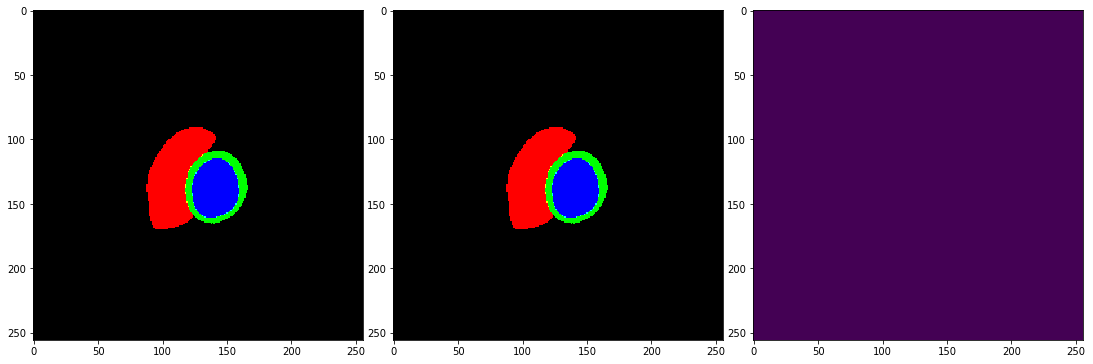

2019-07-14 11:54:32,683 INFO Image-shape: (256, 256)
2019-07-14 11:54:32,683 INFO Image data points: 0
2019-07-14 11:54:32,683 INFO Image mean: 0.000
2019-07-14 11:54:32,683 INFO Image max: 0.000
2019-07-14 11:54:32,683 INFO Image min: 0.000
2019-07-14 11:54:32,683 INFO Mask-shape: (256, 256, 3)
2019-07-14 11:54:32,699 INFO RV mask data points: 2429
2019-07-14 11:54:32,699 INFO Myo mask data points: 809
2019-07-14 11:54:32,699 INFO LV mask data points: 1349
2019-07-14 11:54:32,699 INFO RV mask mean: 0.0370635986328125
2019-07-14 11:54:32,699 INFO Myo mask mean: 0.0123443603515625
2019-07-14 11:54:32,699 INFO LV mask mean: 0.0205841064453125


In [35]:
import scipy
img = 32
for c in range(y[img].shape[-1]):
    if y[img,:,:,c].sum() >= 1:
        print('label: {}, HD scipy: {}'.format(c, scipy.spatial.distance.directed_hausdorff(y[img,:,:,c], pred[img,:,:,c])))
        print('label: {}, HD medpy: {}'.format(c, hd(y[img,:,:,c], y[img,:,:,c])))
show_slice(mask=y[img])
show_slice(mask=pred[img])

In [22]:
for c in range(y[0].shape[-1]):
    if y[img,:,:,c].sum() >= 1:
        print('label: {}, HD: {}'.format(c, hd(y[img,:,:,c].astype(np.bool), pred[img,:,:,c].astype(np.bool))))

label: 0, HD: 106.0


In [38]:
score = jc(pred, y)

In [ ]:
# calculate new metrics

with tf.device(current_gpu):
    # evaluate model
    metrics.append(m_metrics.hd)
    logging.info('evaluate with train data:')
    scores = model.evaluate_generator(batch_generator, max_queue_size=10, verbose=1)
    for m, s in zip(model.metrics_names, scores):
        logging.info('{}: {}'.format(str(m), str(s)[:6]))

    logging.info('evaluate with validation data:')
    scores = model.evaluate_generator(validation_generator, max_queue_size=10, verbose=1)
    for m, s in zip(model.metrics_names, scores):
        logging.info('{}: {}'.format(str(m), str(s)[:6]))

    logging.info('evaluate with test data:')
    scores = model.evaluate_generator(test_generator, max_queue_size=10, verbose=1)
    for m, s in zip(model.metrics_names, scores):
        logging.info('{}: {}'.format(str(m), str(s)[:6]))

In [8]:
# 1st evaluation plot
@interact
def compare_evaluations(plot_type = ['bar', 'line', 'barh', 'hist', 'box', 'kde', 'density', 'area', 'pie'], 
                        filter_by='dice', 
                        filter_by_row='data'):
    '''
    plots the trainings history object
    '''

    ignore = 'background'
    
    evaluation_score = globals().get('evaluation_score', None)
    # check if there are past evaluations
    if type(evaluation_score) == type(pd.DataFrame()):
    
        try:
            # filter
            columns_ = [col for col in evaluation_score.columns if filter_by in col and ignore not in col]
            rows = [idx for idx in evaluation_score.index if filter_by_row in idx]
            # sort
            evaluation_score = evaluation_score.sort_index()
            # select data and plot
            ax = evaluation_score[columns_].loc[rows].plot(kind=plot_type,  figsize=(15,10),  legend=True,  sharey=True, grid = True, fontsize=20, title=EXPERIMENT, rot=60)
            # annotate bars
            for p in ax.patches: 
                ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
            plt.tight_layout()
            # return selected data as dataframe
            return evaluation_score[columns_].loc[rows]

        except Exception as e:
            print(str(e))


interactive(children=(Dropdown(description='plot_type', options=('bar', 'line', 'barh', 'hist', 'box', 'kde', …

## Read both dataframes merge and save for usage in Tableau

In [16]:
df1 = pd.read_csv('reports/evaluation/2D/unet_acdc_spacing1_batch32_drop_04/evaluation_score.csv')
df1['trained'] = 'acdc'
df1

,Evaluation,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv,trained
0,data_raw_ACDC_2D_val_all,1.304614,0.903928,0.017316,0.870847,0.943518,0.887020,acdc
1,data_raw_ACDC_2D_train_all,1.295521,0.930638,0.013884,0.895215,0.958235,0.927599,acdc
2,data_raw_tetra_2D_train_all,1.380633,0.792192,0.014305,0.732852,0.884339,0.759372,acdc
3,data_raw_tetra_2D_val_all,1.393720,0.777663,0.014285,0.705592,0.884016,0.747060,acdc
4,data_raw_tetra_2D_test_all,1.386523,0.792629,0.015073,0.731255,0.894123,0.748515,acdc


In [19]:
df2 = pd.read_csv('reports/evaluation/2D/unet_tetra_spacing1_batch32_drop_04/evaluation_score.csv')
df2['trained'] = 'tetra'

In [20]:
df_merge= pd.concat([df1, df2])
df_merge

,Evaluation,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv,trained
0,data_raw_ACDC_2D_val_all,1.304614,0.903928,0.017316,0.870847,0.943518,0.887020,acdc
1,data_raw_ACDC_2D_train_all,1.295521,0.930638,0.013884,0.895215,0.958235,0.927599,acdc
2,data_raw_tetra_2D_train_all,1.380633,0.792192,0.014305,0.732852,0.884339,0.759372,acdc
3,data_raw_tetra_2D_val_all,1.393720,0.777663,0.014285,0.705592,0.884016,0.747060,acdc
4,data_raw_tetra_2D_test_all,1.386523,0.792629,0.015073,0.731255,0.894123,0.748515,acdc
0,data_raw_tetra_2D_test_all,-0.673843,0.867474,0.842126,0.813158,0.929840,0.849515,tetra
1,data_raw_tetra_2D_val_all,-0.676185,0.859144,0.845325,0.813136,0.921399,0.843903,tetra
2,data_raw_tetra_2D_train_all,-0.677589,0.892193,0.841071,0.825973,0.937627,0.892355,tetra
3,data_raw_ACDC_2D_train_all,-0.536081,0.799330,0.760550,0.748668,0.886538,0.753746,tetra
4,data_raw_ACDC_2D_val_all,-0.547969,0.785349,0.773816,0.727008,0.863211,0.747166,tetra


In [22]:
df_merge.to_csv('reports/evaluation/tetra_vs_acdc_scores_2d.csv', index=False)

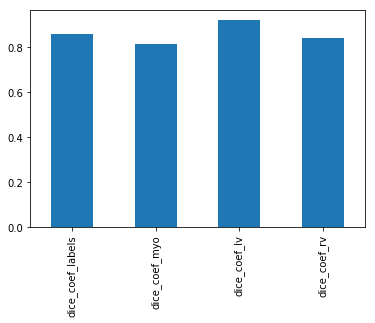

In [7]:
df = evaluation_score
df.fillna(0)
ignore = 'background'
filter_by = 'dice'
columns_ = [col for col in df.columns if filter_by in col and ignore not in col]
#df[columns_].plot(kind='box')
df[columns_].median().plot(kind='bar')

In [6]:
# 1st evaluation plot
@interact
def compare_evaluations(df=[key for key, elem in globals().items() if type(elem) == type(pd.DataFrame())], 
                        plot_type = ['bar', 'line', 'barh', 'hist', 'box', 'kde', 'density', 'area', 'pie'], 
                        filter_by='dice'):
    '''
    plots one dataframe from globals namespace
    '''

    ignore = 'background'
    
    evaluation_score = globals().get(df, None)
    # check if there are past evaluations
    if type(evaluation_score) == type(pd.DataFrame()):
    
        try:
            # filter
            columns_ = [col for col in evaluation_score.columns if filter_by in col and ignore not in col]
            # sort
            evaluation_score = evaluation_score.sort_index()
            # select data and plot
            ax = evaluation_score[columns_].plot(kind=plot_type,  figsize=(15,10),  legend=True,  sharex=True, grid = True, fontsize=20, title=EXPERIMENT, rot=60)
            # annotate bars
            for p in ax.patches: 
                ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
            plt.tight_layout()
            # return selected data as dataframe
            return evaluation_score[columns_].mean()

        except Exception as e:
            print(str(e))

interactive(children=(Dropdown(description='df', options=('evaluation_score',), value='evaluation_score'), Dro…

In [ ]:
evaluation_score['dice_coef'].loc['data_processed_test_':'data_processed_val_'].plot(kind='box')